# **Aprendizaje supervisado**
# SL09. Máquinas de Soporte Vectorial (SVM)

## <font color='blue'>**Máquinas de Soporte Vectorial (SVM)**</font>


Las **máquinas de soporte vectorial (SVM)** son una clase particularmente poderosa y flexible de **algoritmos supervisados** tanto para clasificación como para regresión.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

SVM corresponde a un tipo de clasificación **discriminativa**, que es la que busca modelar cada clase, encontrando una línea o curva (en dos dimensiones) o un plano (en N-dimensiones) que divide las clases entre sí.

Como ejemplo de esto, considere el caso simple de una tarea de clasificación, en la que las dos clases de puntos están bien separadas:

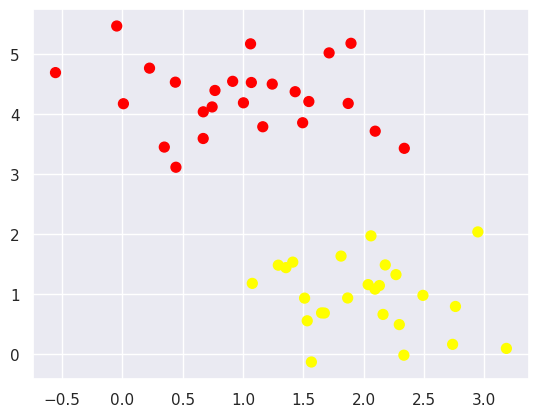

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Un clasificador discriminativo lineal intentaría trazar una línea recta que separe los dos conjuntos de datos y, por lo tanto, crearía un modelo de clasificación. Para datos bidimensionales como el que se muestra aquí, esta es una tarea que podríamos hacer a mano. Pero inmediatamente vemos un problema: **¡hay más de una posible línea divisoria que puede discriminar perfectamente entre las dos clases!**

Podemos dibujarlos de la siguiente manera:

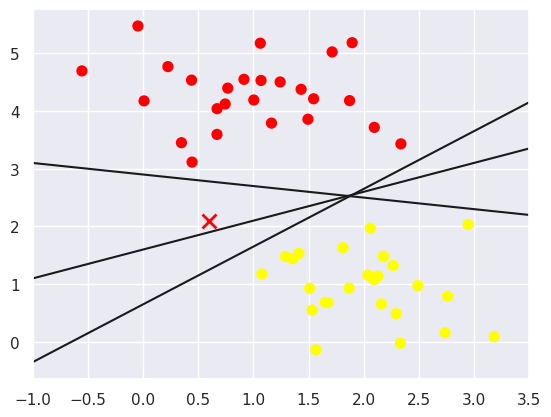

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Se trata de tres separadores muy diferentes que, sin embargo, discriminan perfectamente entre estas muestras. Dependiendo de cuál se elija, a un nuevo punto de datos (por ejemplo, el marcado con la "X" en este gráfico) se le asignará una etiqueta diferente. Evidentemente, nuestra simple intuición de "trazar una línea divisoria entre clases" no es suficiente, y necesitamos pensar un poco más.

## Maximizando el *Margen*

Las máquinas de soporte vectorial ofrecen una forma mejorada de solucionar este problema.

La idea es la siguiente: en lugar de simplemente dibujar una línea de ancho cero entre las clases, podemos dibujar alrededor de cada línea un margen de cierto ancho, hasta el punto más cercano. A continuación, se muestra un ejemplo de cómo podría verse esto:

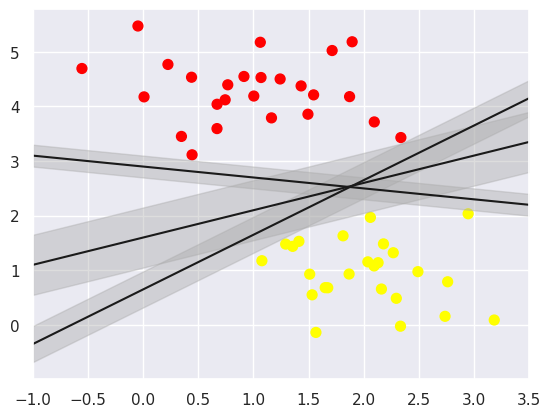

In [5]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

En las SVM, la línea que **maximiza este margen** es la que elegiremos como modelo óptimo. Las SVM son un ejemplo de estimador de margen máximo.

## Ajuste de una máquina de vectores de soporte

Veamos el resultado de un ajuste real a los datos del ejemplo: utilizaremos el clasificador de vectores de soporte de Scikit-Learn para entrenar un modelo SVM sobre estos datos. Por el momento, usaremos un kernel lineal y estableceremos el parámetro C en un número muy grande (discutiremos el significado de estos con más profundidad momentáneamente).

In [6]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

Para visualizar mejor lo que está sucediendo aquí, creemos una función que permita trazar los límites de decisión del SVM:

In [7]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

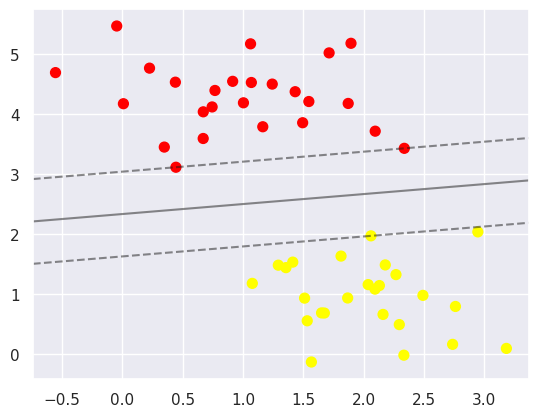

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Esta es la **línea divisoria que maximiza el margen entre los dos conjuntos de puntos**. Observe que algunos de los puntos de entrenamiento solo tocan el margen. Estos puntos son los elementos fundamentales de este ajuste y se conocen como vectores de soporte, y dan nombre al algoritmo. En Scikit-Learn, los valores de estos puntos se almacenan en el atributo *support_vectors_* del clasificador:

In [9]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Una clave del éxito de este clasificador es que para el ajuste, solo importa la posición de los vectores de soporte; ¡Cualquier punto más alejado del margen que esté en el lado correcto no modifica el ajuste! Técnicamente, esto se debe a que estos puntos no contribuyen a la función de pérdida utilizada para ajustar el modelo, por lo que su posición y número no importan siempre que no crucen el margen.

Podemos ver esto, por ejemplo, si graficamos el modelo entrenado con los primeros 60 puntos y luego con los primeros 120 puntos de este conjunto de datos:

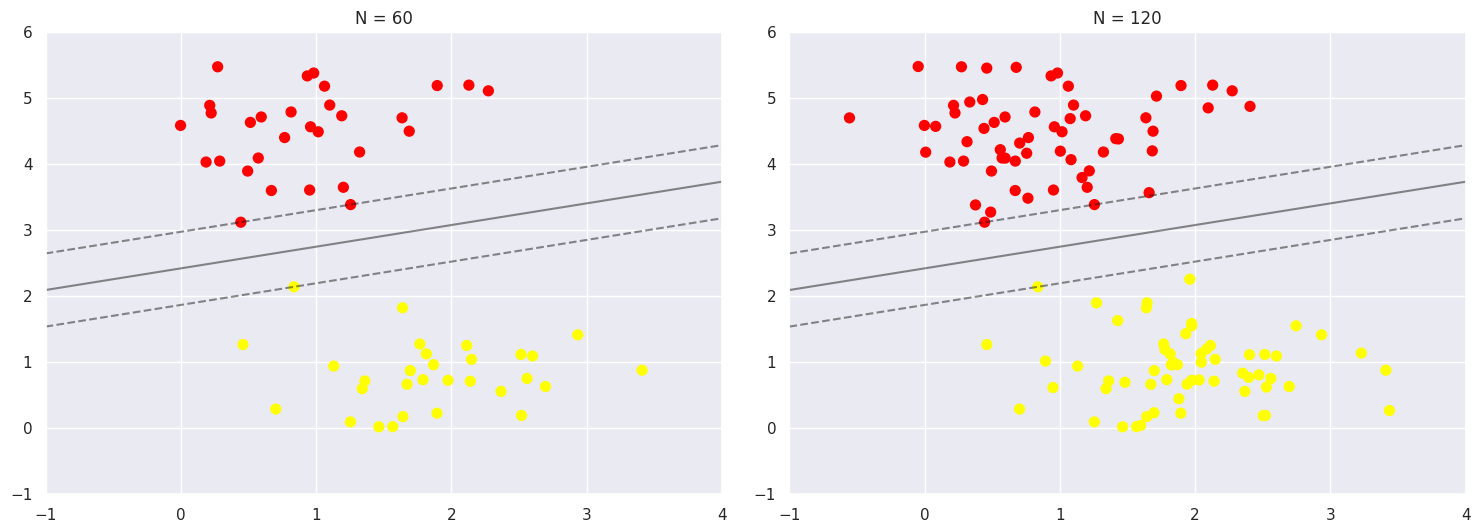

In [10]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

En el gráfico de la izquierda vemos el modelo y los vectores de soporte para 60 puntos de entrenamiento. En el gráfico de la derecha, hemos duplicado el número de puntos de entrenamiento, pero el modelo no ha cambiado: los tres vectores de soporte del gráfico izquierdo siguen siendo los vectores de soporte del gráfico derecho. Esta insensibilidad al comportamiento exacto de los puntos distantes es uno de los puntos fuertes del modelo SVM.

interactive(children=(Dropdown(description='N', options=(10, 50, 100, 200, 1000), value=10), Output()), _dom_c…

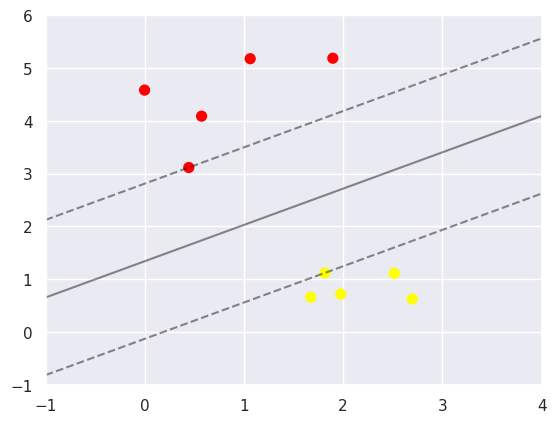

In [11]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 50, 100, 200, 1000], ax=fixed(None));

## <font color='green'>Actividad 1</font>

Entrene una SVM para clasificar correctamente los siguientes datos:

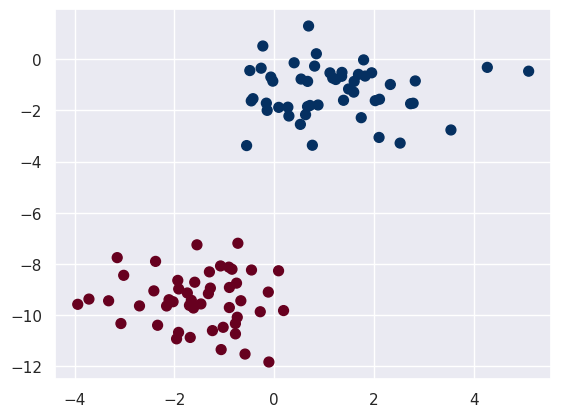

In [12]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

Ajuste la SVM con un kernel lineal.

Grafique los puntos y el plano separador.

<font color='green'>Fin Actividad 1</font>

### Kernel SVM

SVM se vuelve extremadamente poderoso cuando se combina con **kernels**.

La manera más simple de realizar la separación es mediante una línea recta, un plano o un hiperplano N-dimensional.

Desafortunadamente los universos a estudiar no se suelen presentar en casos idílicos de dos dimensiones como en el ejemplo anterior, sino que un algoritmo SVM debe tratar con a) más de dos variables predictoras, b) curvas no lineales de separación, c) casos donde los conjuntos de datos no pueden ser completamente separados, d) clasificaciones en más de dos categorías.

Debido a las limitaciones computacionales de las máquinas de aprendizaje lineal, éstas no pueden ser utilizadas en la mayoría de las aplicaciones del mundo real. **La representación por medio de funciones Kernel ofrece una solución a este problema**, proyectando la información a un espacio de características de mayor dimensión el cual aumenta la capacidad computacional de la máquinas de aprendizaje lineal. Es decir, **mapearemos el espacio de entradas X a un nuevo espacio de características de mayor dimensionalidad (Hilbert)**:

Para motivar la necesidad de kernels, veamos algunos datos que no se pueden separar linealmente:

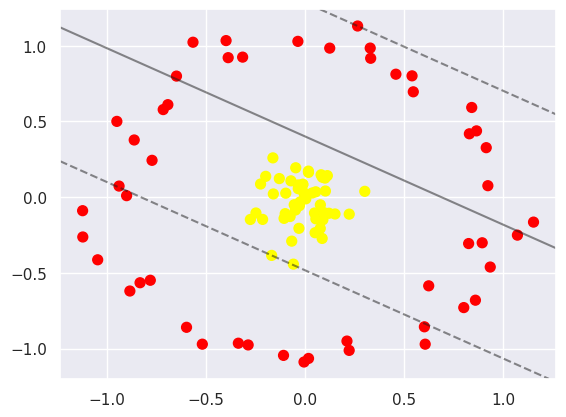

In [14]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Está claro que ninguna discriminación lineal podrá separar estos datos. La solución es proyectar los datos en una dimensión superior de modo que un separador lineal sea suficiente. Por ejemplo, una proyección simple que podríamos usar sería calcular una función de base radial centrada en el grupo del medio:

In [15]:
r = np.exp(-(X ** 2).sum(1))

Podemos visualizar esta dimensión de datos adicional utilizando un gráfico tridimensional:

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

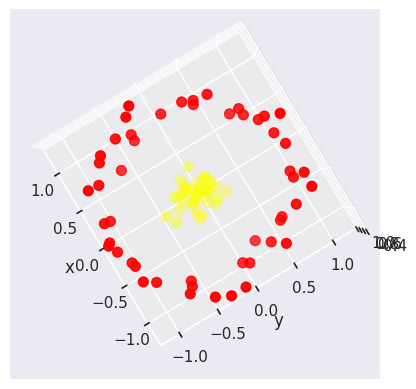

In [16]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

Podemos ver que con esta dimensión adicional, los datos se vuelven trivialmente separables linealmente, dibujando un plano de separación en, digamos, r = 0,7.

Aquí tuvimos que elegir y ajustar cuidadosamente nuestra proyección: si no hubiéramos centrado nuestra función de base radial en la ubicación correcta, no hubiéramos visto resultados tan limpios y linealmente separables. En general, la necesidad de hacer tal elección es un problema: nos gustaría de alguna manera encontrar automáticamente las mejores funciones de base para usar.

Una estrategia para este fin es calcular una función base centrada en cada punto del conjunto de datos y dejar que el algoritmo SVM revise los resultados. Este tipo de transformación de función de base se conoce como transformación de kernel, ya que se basa en una relación de similitud (o kernel) entre cada par de puntos.

Un problema potencial con esta estrategia, proyectar 𝑁 puntos en 𝑁 dimensiones, es que puede volverse muy intensiva en computación a medida que 𝑁 crece. Sin embargo, debido a un pequeño y prolijo procedimiento conocido como el truco del kernel, se puede hacer un ajuste en los datos transformados del kernel de forma implícita, es decir, ¡sin construir la representación 𝑁-dimensional completa de la proyección del kernel! Este truco del kernel está integrado en SVM y es una de las razones por las que el método es tan poderoso.

En Scikit-Learn, podemos aplicar SVM kernelizado simplemente cambiando nuestro kernel lineal a un kernel RBF (función de base radial), usando el hiperparámetro del modelo de kernel:

In [17]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

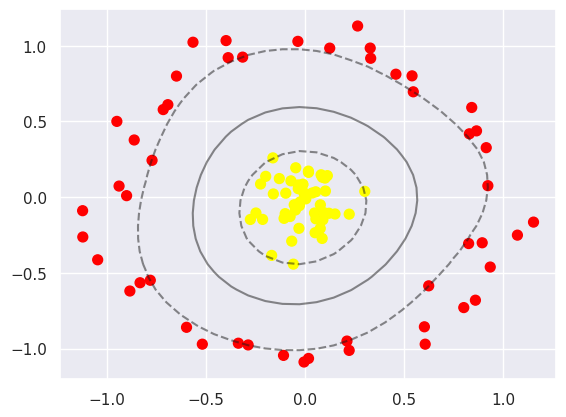

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Usando esta SVM kernelizada, el modelo es capaz de determinar un límite de decisión no lineal adecuado. Esta estrategia de transformación del kernel se usa a menudo en el aprendizaje automático para convertir métodos lineales rápidos en métodos no lineales rápidos, especialmente para modelos en los que se puede usar el truco del kernel.

### Tuning de SVM

Hasta ahora, nuestra discusión se ha centrado en conjuntos de datos muy limpios, en los que existe un límite de decisión perfecto. Pero, ¿qué pasa si sus datos tienen cierta superposición? Por ejemplo, puede tener datos como este:

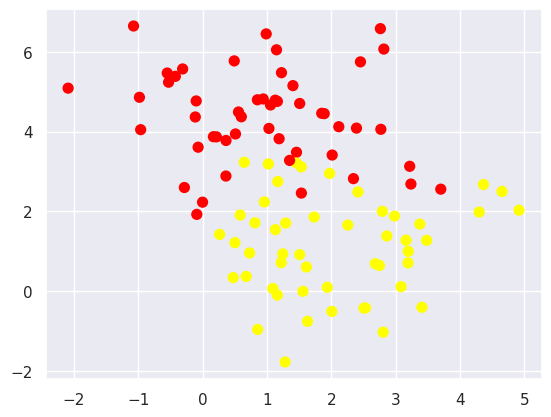

In [19]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Para manejar este caso, la implementación de SVM tiene un pequeño factor de modificación que "suaviza" el margen: es decir, permite que algunos de los puntos se introduzcan en el margen si eso permite un mejor ajuste. La "rigidez" del margen se controla mediante un parámetro de ajuste, más a menudo conocido como 𝐶 (regularización). Para 𝐶 muy grande, el margen es más estricto y los puntos no pueden estar en él. Para 𝐶 más pequeño, el margen es más suave y puede crecer para abarcar algunos puntos.

El gráfico que se muestra a continuación ofrece una imagen visual de cómo un parámetro 𝐶 cambiante afecta el ajuste final, a través de la regularización del margen:

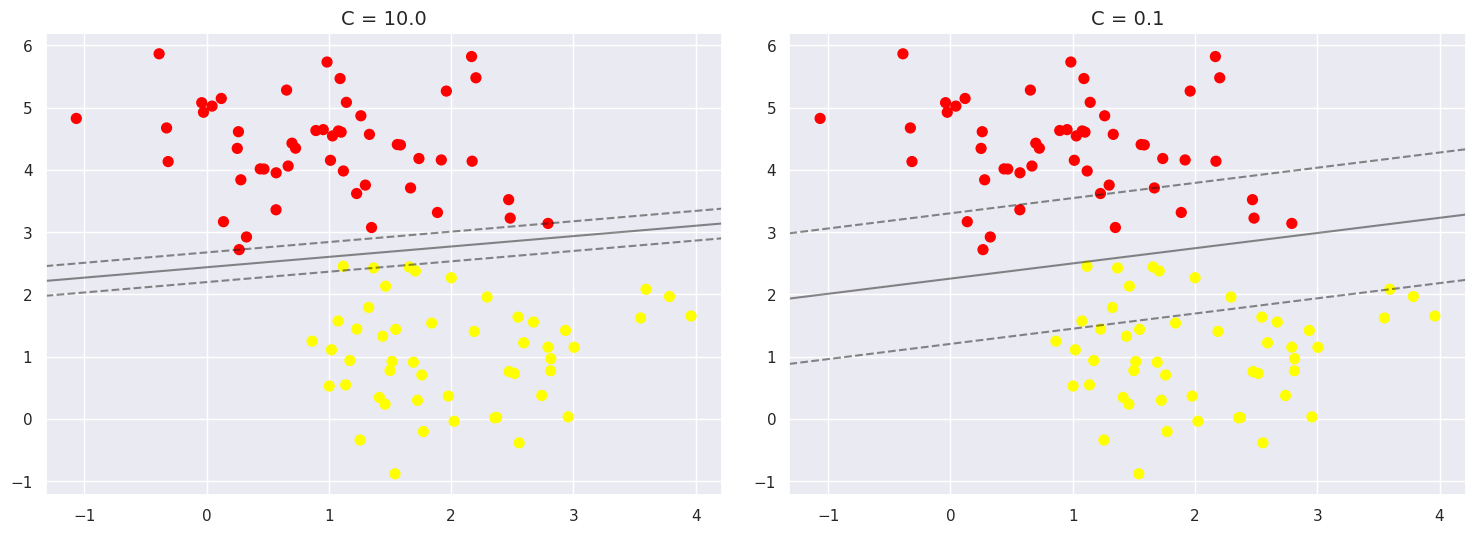

In [20]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

El valor óptimo del parámetro 𝐶 dependerá de su conjunto de datos y debe ajustarse mediante validación cruzada o un procedimiento similar.

## <font color='green'>Actividad 2</font>

Genere un modelo de SVM con kernel RBF, grafique el resultado y muestre el limite de decisión y su margen.

Utilice los siguientes datos:

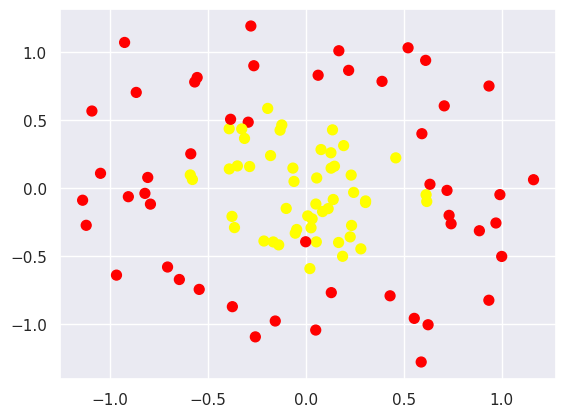

In [21]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.3, noise=.2)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

<font color='green'>Fin Actividad 2</font>

## <font color='blue'>**Ejemplo: Face Recognition**</font>

Como ejemplo de aplicación de SVM, tenemos el problema del reconocimiento facial. Usaremos el conjunto de datos *Labeled Faces in the Wild dataset*, que consta de varios miles de fotos recopiladas de varias figuras públicas. Un buscador para el conjunto de datos está integrado en Scikit-Learn:

In [22]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


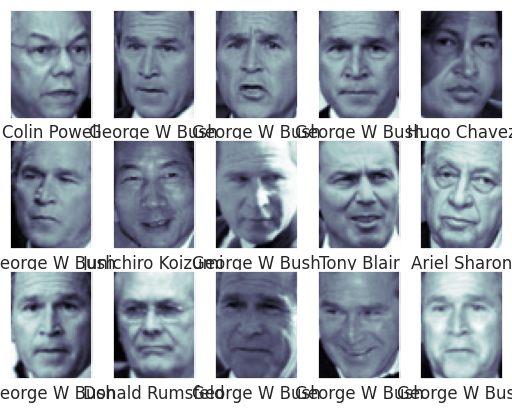

In [23]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Cada imagen es de (62 × 47) píxeles. Podríamos proceder simplemente usando cada valor de píxel como una característica, pero a menudo es más efectivo usar algún tipo de preprocesador para extraer características más significativas; aquí usaremos un análisis de componentes principales para extraer 150 componentes fundamentales para alimentar a nuestro clasificador SVM.

In [24]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [25]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

In [26]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 53.3 s, sys: 38.7 s, total: 1min 32s
Wall time: 1min 2s
{'svc__C': 5, 'svc__gamma': 0.001}


In [27]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

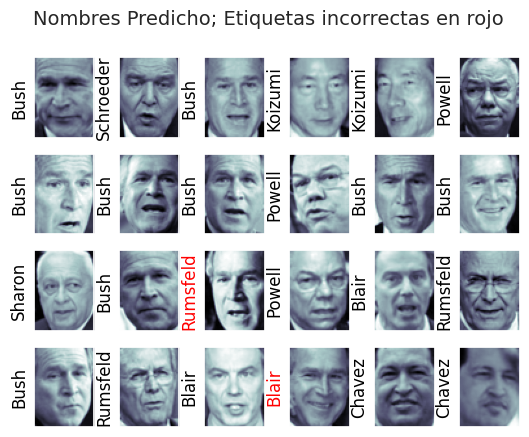

In [28]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Nombres Predicho; Etiquetas incorrectas en rojo', size=14);

In [29]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



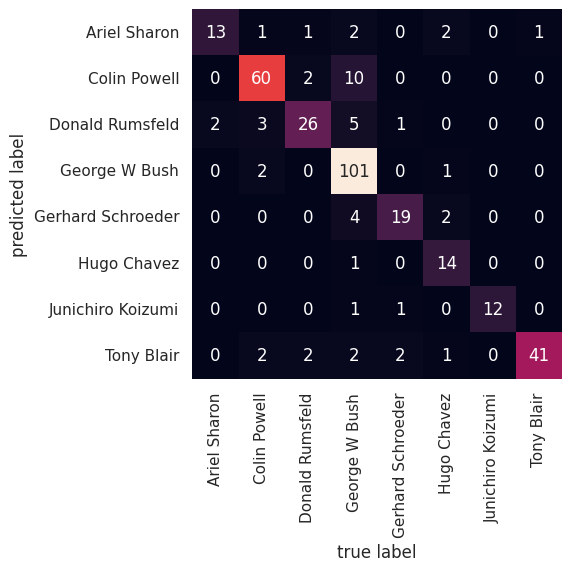

In [30]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

## <font color='blue'>**Resumen de las SVM**</font>

Este método de clasificación es muy poderoso por varias razones:

* Su dependencia de relativamente pocos vectores de soporte significa que son modelos muy compactos y ocupan muy poca memoria.

* Una vez que se entrena el modelo, la fase de predicción es muy rápida.

* Debido a que solo se ven afectados por puntos cercanos al margen, funcionan bien con datos de alta dimensión, incluso datos con más dimensiones que muestras.

* Su integración con los métodos del kernel los hace muy versátiles, capaces de adaptarse a muchos tipos de datos.

Sin embargo, las SVM también tienen varias desventajas:

* La escala con el número de muestras 𝑁 es $O[𝑁^{3}]$ en el peor de los casos, o $O[𝑁^{2}]$ para implementaciones eficientes. Para un gran número de muestras, el costo computacional puede resultar prohibitivo.

* Los resultados dependen en gran medida de una elección adecuada para el parámetro de regularización 𝐶. Este debe elegirse cuidadosamente a través de la validación cruzada, que puede ser costosa a medida que los conjuntos de datos aumentan de tamaño.

* Los resultados no tienen una interpretación probabilística directa. Esto se puede estimar mediante una validación cruzada interna, pero esta estimación adicional es costosa.